In [222]:
import pandas as pd
import tensorflow as tf


In [223]:
# 检查数据
# def check_data(data):
#     print("数据的前几行：")
#     display(data.head())
#     print("\n数据的信息：")
#     data.info()
#     print("\n数据是否有缺失值：")
#     print(data.isnull().sum())
#     print("\n数据的描述统计信息：")
#     display(data.describe())

file_path = './data/SMCI.csv'
data_close = pd.read_csv(file_path)
# check_data(data)

In [224]:
# 读取数据
file_path_IR = './data/IR_daily.csv'
data_IR = pd.read_csv(file_path_IR)

In [225]:
print(data_IR.shape)
print(data_close.shape)

(2609, 2)
(2516, 6)


In [226]:
# 处理DPRIME列中的缺失数据
for idx, value in data_IR['DPRIME'].items():
    if value == '.':
        # 寻找上一格和下一格的索引
        if idx > 0:
            prev_idx = idx - 1
        else:
            prev_idx = idx
        
        if idx < len(data_IR) - 1:
            next_idx = idx + 1
        else:
            next_idx = idx
        
        # 计算平均值并填充
        if data_IR.at[prev_idx, 'DPRIME'] != '.' and data_IR.at[next_idx, 'DPRIME'] != '.':
            avg_value = (float(data_IR.at[prev_idx, 'DPRIME']) + float(data_IR.at[next_idx, 'DPRIME'])) / 2
            formatted_avg_value = f'{avg_value:.2f}'
            data_IR.at[idx, 'DPRIME'] = formatted_avg_value


In [228]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [229]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [230]:
# data_close

In [231]:
# Remove dollar signs and convert to float for specified columns
columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']
for column in columns_to_convert:
    data_close[column] = data_close[column].str.replace('$', '').str.replace(',', '').astype(float)

In [232]:
# Variables
# Time horizon set to be 9 years for training, 1 year for validation

time_steps = 60     # tested [30, 60, 90, 120], 90 is the most efficient one


# Feature
all_features = ['Close/Last', 'Volume', 'Open', 'High', 'Low', 'DPRIME']
selected_features = ['Close/Last']
num_features = len(selected_features)

In [233]:
# Data Preprocessing

In [234]:
# Prepare the complete dataset, called "merged_data"

In [235]:
# 1. Convert 'Date' columns to datetime
data_close['Date'] = pd.to_datetime(data_close['Date'])
data_IR['Date'] = pd.to_datetime(data_IR['DATE'])  # 确保 'DATE' 列名正确

# 2. Merge based on 'Date' column
merged_data = pd.merge(data_close, data_IR[['Date', 'DPRIME']], on='Date', how='inner')

# 3. Print the merged data to check alignment
print("Merged Data:")
print(merged_data.head())

# 4. Check for any missing data after merge
missing_data = merged_data[merged_data.isnull().any(axis=1)]
if not missing_data.empty:
    print("There are rows with mismatched dates:")
    print(missing_data)
else:
    print("All dates in the data are aligned correctly.")

Merged Data:
        Date  Close/Last    Volume   Open    High    Low DPRIME
0 2024-06-21      905.26   7465581 900.10  917.95 863.22    8.5
1 2024-06-20      917.63  13432940 961.29 1014.02 900.32    8.5
2 2024-06-18      920.01   8762073 897.00  938.88 883.31    8.5
3 2024-06-17      887.41   8911764 857.40  921.91 828.09    8.5
4 2024-06-14      844.54   6598781 846.93  872.00 825.61    8.5
All dates in the data are aligned correctly.


In [236]:
# Split the merged data into training and validation

In [237]:
# Filter date range on merged_data and select specific features for train_set and valid_set
train_set = merged_data.loc[(merged_data['Date'] >= '2014-06-24') & (merged_data['Date'] < '2023-06-24'), ['Date'] + selected_features].copy()
valid_set = merged_data.loc[(merged_data['Date'] >= '2023-06-25') & (merged_data['Date'] < '2024-06-21'), ['Date'] + selected_features].copy()

train_set['Date'] = pd.to_datetime(train_set['Date'])
valid_set['Date'] = pd.to_datetime(valid_set['Date'])

print("Training Set:")
print(train_set.head())

print("\nValidation Set:")
print(valid_set.head())


Training Set:
          Date  Close/Last
250 2023-06-23      216.06
251 2023-06-22      226.46
252 2023-06-21      219.91
253 2023-06-20      222.40
254 2023-06-16      230.77

Validation Set:
        Date  Close/Last
1 2024-06-20      917.63
2 2024-06-18      920.01
3 2024-06-17      887.41
4 2024-06-14      844.54
5 2024-06-13      871.10


In [238]:
# Scaling the datasets, using MinMaxScaler

In [239]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train_set[selected_features].values)
valid_data = scaler.transform(valid_set[selected_features].values)

x_train, y_train = [], []
for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :])
    y_train.append(train_data[i, 0])  # Only keep the first column as label

x_valid, y_valid = [], []
for i in range(time_steps, len(valid_data)):
    x_valid.append(valid_data[i-time_steps:i, :])
    y_valid.append(valid_data[i, 0])  # Only keep the first column as label

x_train, y_train = np.array(x_train), np.array(y_train)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(selected_features)))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], len(selected_features)))

# Print the shapes of the processed data
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")


x_train shape: (2206, 60, 1)
y_train shape: (2206,)
x_valid shape: (189, 60, 1)
y_valid shape: (189,)


In [240]:
# 调参：LSTM模型
def build_model(time_steps, num_features):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [241]:
# 调参：训练模型
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [242]:
# 预测函数

@tf.function(reduce_retracing=True)
def make_prediction(model, x_valid):
    return model(x_valid, training=False)

In [243]:
# 构建模型
model = build_model(time_steps, num_features=num_features)
train_model(model, x_train, y_train)

# 将验证集数据转换为张量
x_valid_tensor = tf.convert_to_tensor(x_valid, dtype=tf.float32)

# 预测
valid_preds = make_prediction(model, x_valid_tensor)

# Ensure valid_preds has the correct shape
valid_preds = np.squeeze(valid_preds, axis=-1)  # Remove singleton dimension if present
# valid_preds = scaler.inverse_transform(valid_preds.reshape(-1, 1))

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0593e-04
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8952e-04
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.6471e-04
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5349e-04
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4488e-04
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4014e-04
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.5865e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2930e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1398e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1060e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4113e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0768e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2477e-04
Epoch 15/25
69/69 ━━━━━━━━━━━━

In [245]:
print(valid_preds)

[2.839589   2.8521104  2.832775   2.8164349  2.7702098  2.739266
 2.7543693  2.7972355  2.8563259  2.9220366  2.9607968  2.958978
 2.976721   2.9936323  2.9934483  2.9811273  2.9650235  2.886769
 2.8072996  2.718585   2.663267   2.6346524  2.6100073  2.6489034
 2.5700972  2.5287054  2.5024333  2.5840113  2.5989985  2.5671523
 2.5255687  2.471026   2.4023173  2.3373456  2.2850437  2.2362845
 2.1500275  2.078207   1.9883273  1.9036357  1.8260258  1.7530615
 1.6991808  1.6596365  1.6259383  1.5883327  1.5498776  1.4406242
 1.3372039  1.2584457  1.2140003  1.1951561  1.1909643  1.1958072
 1.1869138  1.1555328  1.1201036  1.0835367  1.0574068  1.0395383
 1.0342613  1.0378386  1.0441424  1.0472934  1.059629   1.0710326
 1.090402   1.1131006  1.1161338  1.1075554  1.0801294  1.0450724
 1.0110852  0.9915625  0.96914876 0.94892555 0.94072163 0.9414169
 0.9483926  0.95969105 0.9812156  1.0008281  1.0196942  1.0308133
 1.0374662  1.0430543  1.0576997  1.0604733  1.0550987  1.0503697
 1.050861   1

LSTM RMSE on validation set: 485.73647629724644


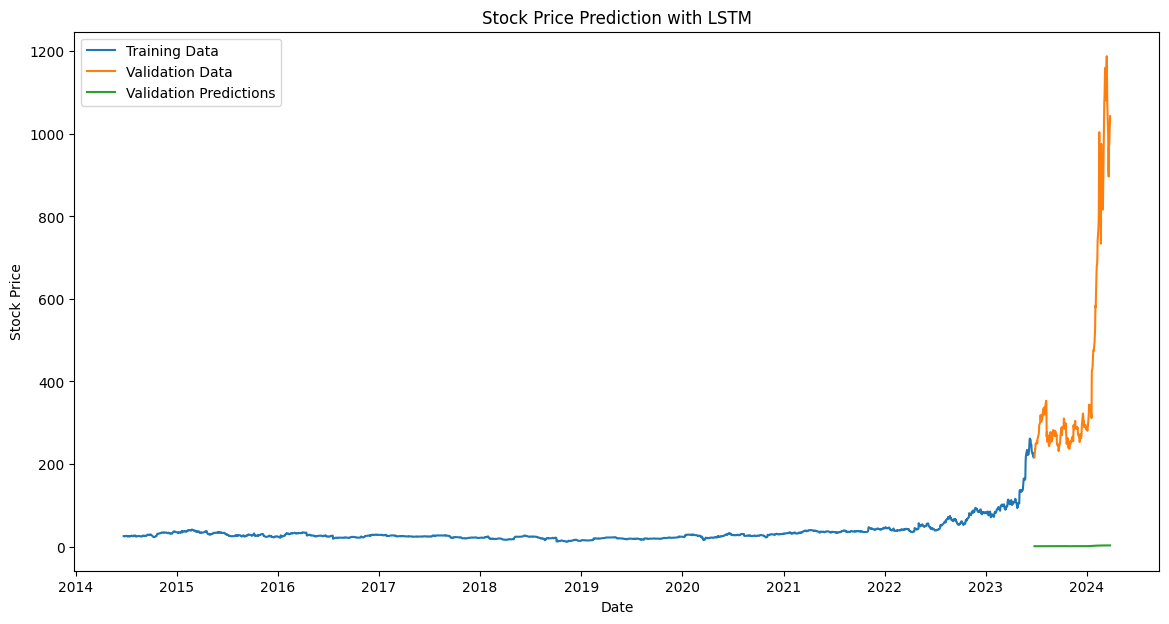

In [244]:
# 计算验证集上的RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# 可视化LSTM结果
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()